In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]

import warnings

warnings.filterwarnings("ignore")

In [2]:
# 內存優化
d_types1 = {
    "user_id": "int32",
    "item_id": "int32",
    "cat_id": "int16",
    "seller_id": "int16",
    "brand_id": "float32",
    "time_stamp": "int16",
    "action_type": "int8",
}
d_types2 = {"user_id": "int32", "age_range": "float32", "gender": "float32"}
d_types3 = {"user_id": "int32", "merchant_id": "int16", "label": "float32"}

In [3]:
df_train = pd.read_csv("./dataset/train_format1.csv", dtype=d_types3)
df_test = pd.read_csv("./dataset/test_format1.csv", dtype=d_types3)
user_info = pd.read_csv("./dataset/user_info_format1.csv", dtype=d_types2)
user_log = pd.read_csv("./dataset/user_log_format1.csv", dtype=d_types3)

In [4]:
display(user_log.head())
display(user_info.head())
display(df_train.head())
display(df_test.head())

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


,user_id,merchant_id,label
0,34176,3906,0.0
1,34176,121,0.0
2,34176,4356,1.0
3,34176,2217,0.0
4,230784,4818,0.0


,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


## 資料前處理


### 檢查資料類型


In [5]:
display(user_log.info())
display(user_info.info())
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int32  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int32(1), int64(5)
memory usage: 2.7 GB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int32  
 1   age_range  421953 non-null  float32
 2   gender     417734 non-null  float32
dtypes: float32(2), int32(1)
memory usage: 4.9 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      260864 non-null  int32  
 1   merchant_id  260864 non-null  int16  
 2   label        260864 non-null  float32
dtypes: float32(1), int16(1), int32(1)
memory usage: 2.5 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261477 entries, 0 to 261476
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      261477 non-null  int32  
 1   merchant_id  261477 non-null  int16  
 2   prob         0 non-null       float64
dtypes: float64(1), int16(1), int32(1)
memory usage: 3.5 MB


None

### 缺失值處理


In [6]:
def show_missing_info(df, df_name):
    # 計算缺失值
    missing_count = df.isnull().sum()
    missing_percent = df.isnull().mean() * 100

    # 創建結果DataFrame
    missing_info = pd.DataFrame(
        {"value": missing_count, "ratio(%)": missing_percent.round(2)}
    )

    # 輸出結果
    print(f"=== {df_name} 缺失值資訊 ===")
    print(missing_info)
    print("\n")


# 顯示資料框的缺值資訊
show_missing_info(user_info, "User Info")
show_missing_info(user_log, "User Log")

=== User Info 缺失值資訊 ===
           value  ratio(%)
user_id        0      0.00
age_range   2217      0.52
gender      6436      1.52


=== User Log 缺失值資訊 ===
             value  ratio(%)
user_id          0      0.00
item_id          0      0.00
cat_id           0      0.00
seller_id        0      0.00
brand_id     91015      0.17
time_stamp       0      0.00
action_type      0      0.00




In [7]:
# NaN 當未知
# 使用 0 替換 NaN(age_range)
# 使用 2 替換 NaN(gender、brand_id)

user_info["age_range"].replace(np.nan, 0, inplace=True)
user_info["gender"].replace(np.nan, 2, inplace=True)

user_log["brand_id"].replace(np.nan, 0, inplace=True)

# 檢查缺值有沒有處理乾淨
print("=== 缺失值數量 ===")
print(user_info.isnull().sum())
print(user_log.isnull().sum())

=== 缺失值數量 ===
user_id      0
age_range    0
gender       0
dtype: int64
user_id        0
item_id        0
cat_id         0
seller_id      0
brand_id       0
time_stamp     0
action_type    0
dtype: int64


### 特徵建立


In [8]:
# 合併 train data 和 test data
df_train["data"] = "train"
df_test["data"] = "test"
data = pd.concat([df_train, df_test])
data = data.drop(["prob"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 522341 entries, 0 to 261476
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      522341 non-null  int32  
 1   merchant_id  522341 non-null  int16  
 2   label        260864 non-null  float32
 3   data         522341 non-null  object 
dtypes: float32(1), int16(1), int32(1), object(1)
memory usage: 13.0+ MB


In [9]:
# 統計性別和年齡

# 合並
data = pd.merge(data, user_info)
data.head()

,user_id,merchant_id,label,data,age_range,gender
0,34176,3906,0.0,train,6.0,0.0
1,34176,121,0.0,train,6.0,0.0
2,34176,4356,1.0,train,6.0,0.0
3,34176,2217,0.0,train,6.0,0.0
4,230784,4818,0.0,train,0.0,0.0


#### 用戶-賣家特徵(按照 user_id, merchant_id 分組)


In [10]:
# 統計交互過的商品

uniq_item_id = (
    user_log.groupby(["user_id", "seller_id", "item_id"])
    .count()
    .reset_index()[["user_id", "seller_id", "item_id"]]
)

uniq_item_id_count = (
    uniq_item_id.groupby(["user_id", "seller_id"]).count().reset_index()
)

uniq_item_id_count.rename(
    columns={"seller_id": "merchant_id", "item_id": "uniq_item_id"}, inplace=True
)

# 合併
data = pd.merge(data, uniq_item_id_count)
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id
0,34176,3906,0.0,train,6.0,0.0,20
1,34176,121,0.0,train,6.0,0.0,1
2,34176,4356,1.0,train,6.0,0.0,2
3,34176,2217,0.0,train,6.0,0.0,1
4,230784,4818,0.0,train,0.0,0.0,1


In [11]:
# 統計交互過的品類

cat_id_temp = (
    user_log.groupby(["user_id", "seller_id", "cat_id"])
    .count()
    .reset_index()[["user_id", "seller_id", "cat_id"]]
)

cat_id_temp_count = cat_id_temp.groupby(["user_id", "seller_id"]).count().reset_index()

cat_id_temp_count.rename(
    columns={"seller_id": "merchant_id", "cat_id": "total_cat_id"}, inplace=True
)

# 合併
data = pd.merge(data, cat_id_temp_count)
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id,total_cat_id
0,34176,3906,0.0,train,6.0,0.0,20,6
1,34176,121,0.0,train,6.0,0.0,1,1
2,34176,4356,1.0,train,6.0,0.0,2,1
3,34176,2217,0.0,train,6.0,0.0,1,1
4,230784,4818,0.0,train,0.0,0.0,1,1


In [12]:
# 統計交互天數

time_temp = (
    user_log.groupby(["user_id", "seller_id", "time_stamp"])
    .count()
    .reset_index()[["user_id", "seller_id", "time_stamp"]]
)

time_temp_count = time_temp.groupby(["user_id", "seller_id"]).count().reset_index()

time_temp_count.rename(
    columns={"seller_id": "merchant_id", "time_stamp": "total_time_temp"}, inplace=True
)

# 合併
data = pd.merge(data, time_temp_count)
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id,total_cat_id,total_time_temp
0,34176,3906,0.0,train,6.0,0.0,20,6,9
1,34176,121,0.0,train,6.0,0.0,1,1,3
2,34176,4356,1.0,train,6.0,0.0,2,1,2
3,34176,2217,0.0,train,6.0,0.0,1,1,1
4,230784,4818,0.0,train,0.0,0.0,1,1,3


In [13]:
# 統計點擊、添加購物車、購買、添加到我的最愛的操作次數

click_temp = (
    user_log.groupby(["user_id", "seller_id", "action_type"])["item_id"]
    .count()
    .reset_index()
)

click_temp.rename(
    columns={"seller_id": "merchant_id", "item_id": "times"}, inplace=True
)

click_temp["clicks"] = click_temp["action_type"] == 0

click_temp["clicks"] = click_temp["clicks"] * click_temp["times"]

click_temp["shopping_cart"] = click_temp["action_type"] == 1
click_temp["shopping_cart"] = click_temp["shopping_cart"] * click_temp["times"]

click_temp["purchases"] = click_temp["action_type"] == 2
click_temp["purchases"] = click_temp["purchases"] * click_temp["times"]

click_temp["favourites"] = click_temp["action_type"] == 3
click_temp["favourites"] = click_temp["favourites"] * click_temp["times"]

features = click_temp.groupby(["user_id", "merchant_id"]).sum().reset_index()

features = features.drop(["action_type", "times"], axis=1)

# 合併
data = pd.merge(data, features)
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id,total_cat_id,total_time_temp,clicks,shopping_cart,purchases,favourites
0,34176,3906,0.0,train,6.0,0.0,20,6,9,36,0,1,2
1,34176,121,0.0,train,6.0,0.0,1,1,3,13,0,1,0
2,34176,4356,1.0,train,6.0,0.0,2,1,2,12,0,6,0
3,34176,2217,0.0,train,6.0,0.0,1,1,1,1,0,1,0
4,230784,4818,0.0,train,0.0,0.0,1,1,3,7,0,1,0


In [14]:
# 購買點擊率
data["purchases_ctr"] = data["purchases"] / data["clicks"]
data.head()

,user_id,merchant_id,label,data,age_range,gender,uniq_item_id,total_cat_id,total_time_temp,clicks,shopping_cart,purchases,favourites,purchases_ctr
0,34176,3906,0.0,train,6.0,0.0,20,6,9,36,0,1,2,0.027778
1,34176,121,0.0,train,6.0,0.0,1,1,3,13,0,1,0,0.076923
2,34176,4356,1.0,train,6.0,0.0,2,1,2,12,0,6,0,0.500000
3,34176,2217,0.0,train,6.0,0.0,1,1,1,1,0,1,0,1.000000
4,230784,4818,0.0,train,0.0,0.0,1,1,3,7,0,1,0,0.142857


In [15]:
# 儲存提取好的特徵
data.to_csv("./dataset/features.csv", index=False)

### 壓縮資料


In [81]:
new_data = pd.read_csv("./dataset/features.csv")

In [82]:
# 壓縮資料
fcols = new_data.select_dtypes("float").columns
icols = new_data.select_dtypes("integer").columns
new_data[fcols] = new_data[fcols].apply(pd.to_numeric, downcast="float")
new_data[icols] = new_data[icols].apply(pd.to_numeric, downcast="integer")

new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522341 entries, 0 to 522340
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          522341 non-null  int32  
 1   merchant_id      522341 non-null  int16  
 2   label            260864 non-null  float32
 3   data             522341 non-null  object 
 4   age_range        522341 non-null  float32
 5   gender           522341 non-null  float32
 6   uniq_item_id     522341 non-null  int16  
 7   total_cat_id     522341 non-null  int8   
 8   total_time_temp  522341 non-null  int8   
 9   clicks           522341 non-null  int16  
 10  shopping_cart    522341 non-null  int8   
 11  purchases        522341 non-null  int8   
 12  favourites       522341 non-null  int16  
 13  purchases_ctr    522341 non-null  float32
dtypes: float32(4), int16(4), int32(1), int8(4), object(1)
memory usage: 19.9+ MB


### 資料分割


In [83]:
# 分成訓練集和測試集
train = new_data[new_data["data"] == "train"]
test = new_data[new_data["data"] == "test"].drop(["data", "label"], axis=1)

In [84]:
X, y = train.drop(["user_id", "merchant_id", "label", "data"], axis=1), train["label"]

# 無限值替換成0
X.replace([np.inf, -np.inf], 0, inplace=True)

In [85]:
# 分成訓練集和驗證集
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [86]:
# 正樣本比例
print("訓練集正樣本比例: ", y_train.mean())
print("驗證集正樣本比例: ", y_valid.mean())

訓練集正樣本比例:  0.06141616
驗證集正樣本比例:  0.060088553


In [87]:
# 取得 user_id & merchant_id
test_data_id = new_data[new_data["data"] == "test"][["user_id", "merchant_id"]]

# 預測的測試集
pre_test = test.drop(["user_id", "merchant_id"], axis=1)

# 無限值替換成0
pre_test.replace([np.inf, -np.inf], 0, inplace=True)

## 預測模型


In [88]:
from sklearn.metrics import roc_auc_score, roc_curve

##### 隨機森林(RandomForest)


In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
# 最佳參數建立模型(參考 best_model_parameter.ipynb)
best_rf = RandomForestClassifier(
    max_depth=5, min_samples_leaf=50, min_samples_split=2, n_estimators=50
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=50, n_estimators=50)

In [91]:
# 計算準確率
print("accuracy: ", best_rf.score(X_valid, y_valid))

# 計算 AUC
rf_best_roc = roc_auc_score(y_valid, best_rf.predict_proba(X_valid)[:, 1])
print("roc_auc: ", rf_best_roc)

accuracy:  0.9399114484503479
roc_auc:  0.61029165742181


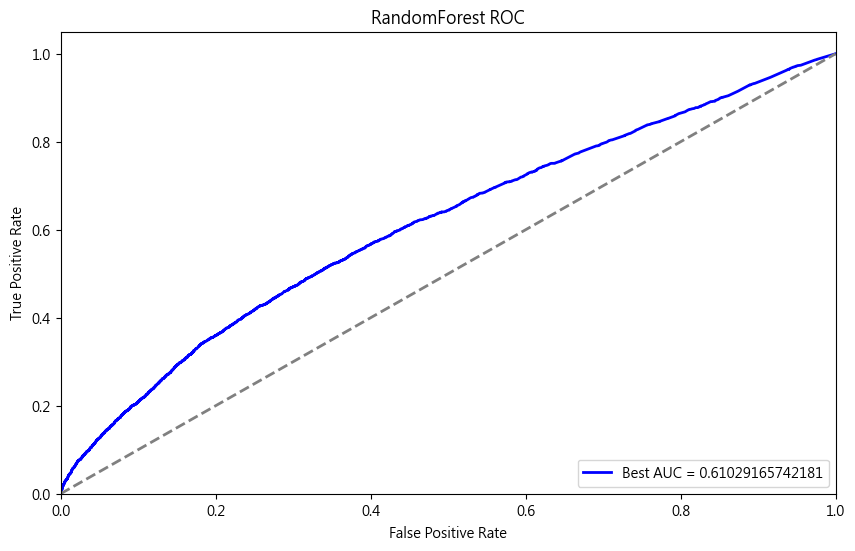

In [121]:
# 計算 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_valid, best_rf.predict_proba(X_valid)[:, 1])

# 繪製 ROC 曲線
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"Best AUC = {rf_best_roc}")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RandomForest ROC")
plt.legend(loc="lower right")
plt.show()

In [93]:
# 預測測試集
rf_predict_proba = best_rf.predict_proba(pre_test)
print(rf_predict_proba[:, 1])

[0.04089205 0.11014792 0.0462324  ... 0.09562136 0.04594989 0.04415796]


##### 邏輯迴歸(LogisticRegression)


In [94]:
from sklearn.linear_model import LogisticRegression

In [95]:
# 最佳參數建立模型(參考 best_model_parameter.ipynb)
best_lg = LogisticRegression(C=0.1, penalty="l1", solver="liblinear")
best_lg.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [96]:
# 計算準確率
print("accuracy: ", best_lg.score(X_valid, y_valid))

# 計算 AUC
lg_best_roc = roc_auc_score(y_valid, best_lg.predict_proba(X_valid)[:, 1])
print("roc_auccuracy: ", lg_best_roc)

accuracy:  0.9397772794357234
roc_auccuracy:  0.6065453878068585


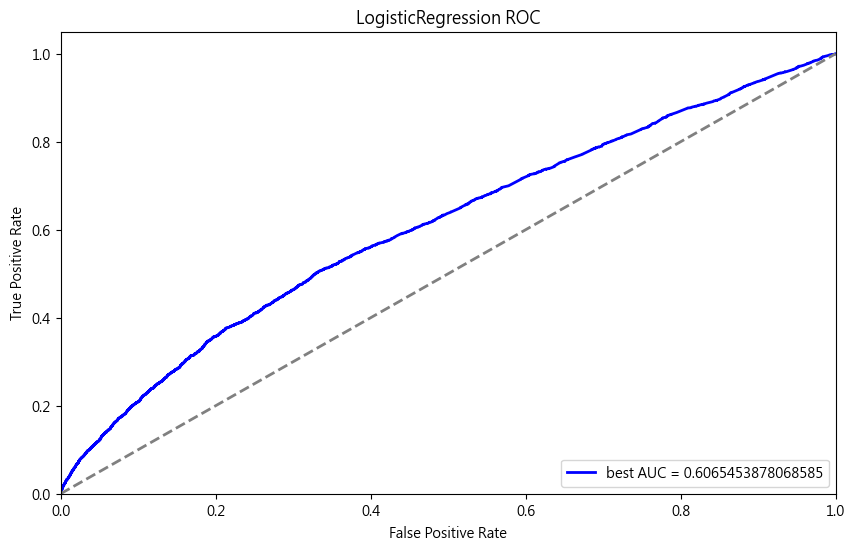

In [123]:
# 計算
fpr, tpr, thresholds = roc_curve(y_valid, best_lg.predict_proba(X_valid)[:, 1])

# 繪製 ROC 曲線
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"best AUC = {lg_best_roc}")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LogisticRegression ROC")
plt.legend(loc="lower right")
plt.show()

In [98]:
# 預測測試集
lg_predict_proba = best_lg.predict_proba(pre_test)
print(lg_predict_proba[:, 1])

[0.04453291 0.10145398 0.05492361 ... 0.10897164 0.04596196 0.04918268]


##### XGBoost


In [99]:
from xgboost import XGBClassifier

In [100]:
# 最佳參數建立模型(參考 best_model_parameter.ipynb)

best_xgc = XGBClassifier(
    eta=0.1,
    eval_metric="auc",
    gamma=1,
    max_depth=1,
    min_child_weight=10,
    objective="binary:logistic",
    subsample=0.5,
)

best_xgc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='auc',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [101]:
# 計算準確率
print("accuracy: ", best_xgc.score(X_valid, y_valid))

# 計算 AUC
xgc_roc_auc = roc_auc_score(y_valid, best_xgc.predict_proba(X_valid)[:, 1])
print("roc_auc: ", xgc_roc_auc)

accuracy:  0.9399114484503479
roc_auc:  0.611187450698163


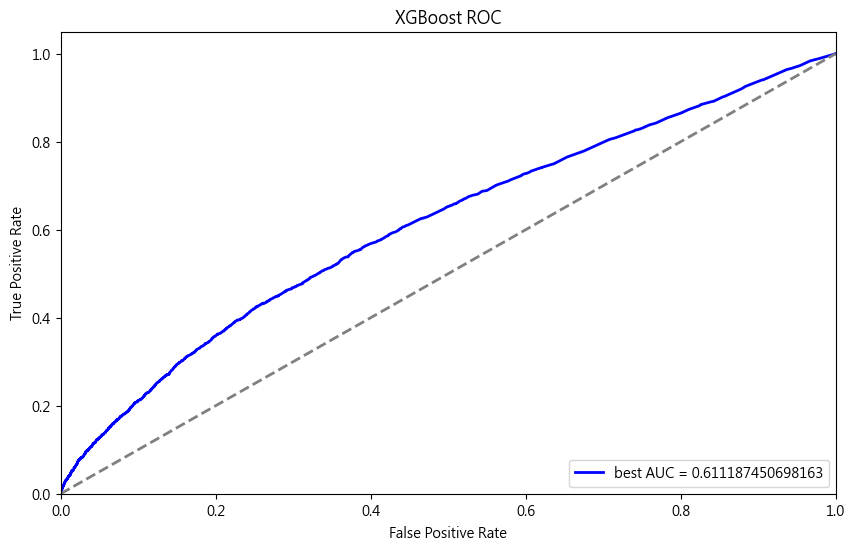

In [125]:
# 計算 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_valid, best_xgc.predict_proba(X_valid)[:, 1])

# 繪製 ROC 曲線
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"best AUC = {xgc_roc_auc}")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC")
plt.legend(loc="lower right")
plt.show()

In [103]:
# 預測
xgc_predict_proba = best_xgc.predict_proba(pre_test)
print(xgc_predict_proba[:, 1])

[0.04068149 0.11608021 0.04523351 ... 0.09578151 0.04574646 0.04230592]


##### LightGBM


In [104]:
from lightgbm import LGBMClassifier

In [105]:
# 最佳參數建立模型(參考 best_model_parameter.ipynb)

best_lgbm = LGBMClassifier(
    boosting_type="goss",
    learning_rate=0.05,
    max_depth=50,
    min_split_gain=0.05,
    num_leaves=10,
    subsample=0.5,
)
best_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 12817, number of negative: 195874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 208691, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061416 -> initscore=-2.726699
[LightGBM] [Info] Start training from sc

LGBMClassifier(boosting_type='goss', learning_rate=0.05, max_depth=50,
               min_split_gain=0.05, num_leaves=10, subsample=0.5)

In [106]:
# 計算準確率
accuracy = best_lgbm.score(X_valid, y_valid)
print("accuracy: ", accuracy)

# 計算 AUC
lgbm_roc_auc = roc_auc_score(y_valid, best_lgbm.predict_proba(X_valid)[:, 1])
print("roc_auc: ", lgbm_roc_auc)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
accuracy:  0.9399114484503479
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
roc_auc:  0.6143968518896877


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


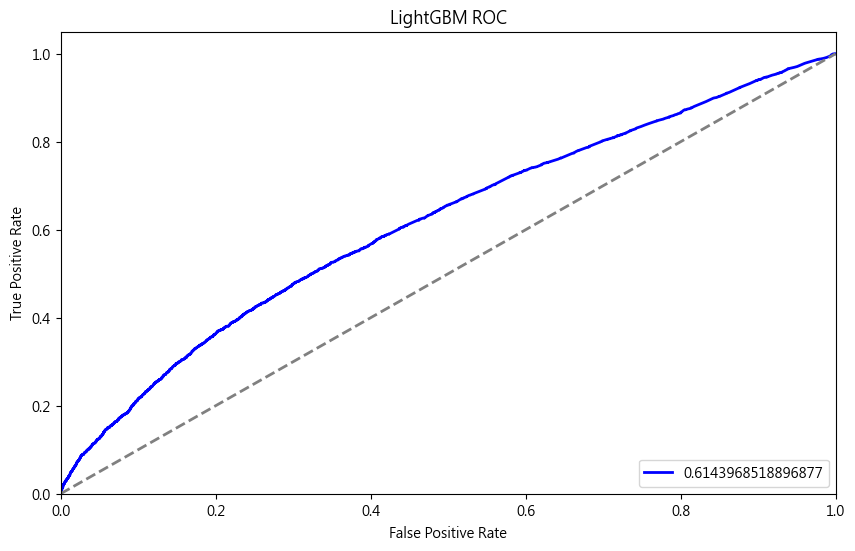

In [126]:
# 計算 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_valid, best_lgbm.predict_proba(X_valid)[:, 1])

# 繪製 ROC 曲線
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"best AUC = {lgbm_roc_auc}")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LightGBM ROC")
plt.legend(loc="lower right")
plt.show()

In [108]:
# 預測測試集
lgbm_predict_proba = best_lgbm.predict_proba(pre_test)
print(lgbm_predict_proba[:, 1])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[0.04020478 0.10359374 0.04505427 ... 0.10323147 0.04687928 0.04084306]


### 最佳模型選擇


In [109]:
# 調過最佳參數
# 使用 predict_proba 方法獲取預測概率

best_auc_lg = roc_auc_score(y_valid, best_lg.predict_proba(X_valid)[:, 1])
best_auc_rf = roc_auc_score(y_valid, best_rf.predict_proba(X_valid)[:, 1])
best_auc_xgc = roc_auc_score(y_valid, best_xgc.predict_proba(X_valid)[:, 1])
best_auc_lgbm = roc_auc_score(y_valid, best_lgbm.predict_proba(X_valid)[:, 1])

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [110]:
# 比較模型的 AUC
scores = pd.DataFrame(
    {
        "model": ["LogisticRegression", "RandomForest", "XGBoost", "LightGBM"],
        "auc": [best_auc_lg, best_auc_rf, best_auc_xgc, best_auc_lgbm],
    }
)

scores.sort_values(by="auc", ascending=False)

,model,auc
3,LightGBM,0.614397
2,XGBoost,0.611187
1,RandomForest,0.610292
0,LogisticRegression,0.606545


In [115]:
# 儲存最佳模型預測結果
list1 = []
for i in lgbm_predict_proba[:, 1]:
    list1.append(i)

user_id_list = test_data_id["user_id"].tolist()
merchant_id_list = test_data_id["merchant_id"].tolist()

lgbm_prob = pd.DataFrame(
    {"user_id": user_id_list, "merchant_id": merchant_id_list, "prob": list1}
)
lgbm_prob.to_csv("prediction.csv", index=False)

## 結果探討


In [116]:
# 讀取 result.csv 檔案
result_df = pd.read_csv("prediction.csv")

# 預測機率基本統計描述
result_df.head()

,user_id,merchant_id,prob
0,163968,4605,0.040205
1,360576,1581,0.103594
2,98688,1964,0.045054
3,98688,3645,0.045525
4,295296,3361,0.080380


In [117]:
# 預測機率基本統計描述
print(result_df["prob"].describe())

count    261477.000000
mean          0.061398
std           0.030445
min           0.025797
25%           0.042233
50%           0.050314
75%           0.070980
max           0.623288
Name: prob, dtype: float64


In [118]:
# 定義機率區間
bins = [0, 0.04, 0.06, 0.08, 0.10, 1]
labels = ["<4%", "4-6%", "6-8%", "8-10%", ">10%"]

# 計算各區間的使用者數量和百分比
result_df["prob_range"] = pd.cut(result_df["prob"], bins=bins, labels=labels)
distribution = result_df["prob_range"].value_counts().sort_index()
percentage = result_df["prob_range"].value_counts(normalize=True).sort_index() * 100

print("\n區間      人數     百分比")
print("-" * 30)
for label, count, pct in zip(labels, distribution, percentage):
    print(f"{label:>6} {count:>8} {pct:>8.2f}%")


區間      人數     百分比
------------------------------
   <4%    38977    14.91%
  4-6%   131562    50.31%
  6-8%    43980    16.82%
 8-10%    22681     8.67%
  >10%    24277     9.28%


## 參考資料

資料集

https://tianchi.aliyun.com/competition/entrance/231576/information

用戶的復購預測

https://www.heywhale.com/mw/project/6044a21f6b48c2001529f1b5/content
